In [1]:
# %% [markdown]
# Title: Neural Network Compression on CIFAR-10 (Pruning + Low-Rank)
# Notebook goal: Baseline -> Pruning sweeps -> Low-rank factorization (SVD) -> Fine-tune -> Pareto analysis.
# No emojis. Plenty of receipts.

# %%
import os, math, time, copy, random, json, gc
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple, Any

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils import prune
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt

# matplotlib sane defaults
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.grid"] = True

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 1337

def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

print(f"Device: {DEVICE}")


Device: cuda


In [2]:
# %%
DATA_DIR = "./data"
BATCH_SIZE = 128
VAL_SPLIT = 5000  # 45k train / 5k val from original 50k train
NUM_WORKERS = min(4, os.cpu_count() or 0)

# CIFAR-10 stats
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

full_train = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_tf)
test_set   = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_tf)

train_len = len(full_train) - VAL_SPLIT
val_len   = VAL_SPLIT
train_set, val_set = random_split(full_train, [train_len, val_len], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Train/Val/Test sizes: {len(train_set)}/{len(val_set)}/{len(test_set)}")


100%|██████████| 170M/170M [00:15<00:00, 10.9MB/s] 


Train/Val/Test sizes: 45000/5000/10000


In [3]:
# %%
def build_resnet18_cifar(num_classes=10):
    m = models.resnet18(weights=None)
    # Adjust first conv for CIFAR-10 (32x32) if you want slightly leaner early stem
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

baseline_model = build_resnet18_cifar().to(DEVICE)
sum(p.numel() for p in baseline_model.parameters()), sum(p.numel() for p in baseline_model.parameters() if p.requires_grad)

(11173962, 11173962)

In [4]:
# %%
@torch.no_grad()
def accuracy(model, loader):
    model.eval()
    correct=0; total=0
    for x,y in loader:
        x=x.to(DEVICE, non_blocking=True); y=y.to(DEVICE, non_blocking=True)
        logits = model(x)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item()
        total += y.size(0)
    return correct/total

def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    nonzero = sum((p != 0).sum().item() for p in model.parameters())
    return total, nonzero

def model_size_mb(model, dtype_bytes=4):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params * dtype_bytes / (1024**2)

def estimate_flops(model, input_size=(1,3,32,32)):
    # Minimalistic forward-hook FLOPs counter for Conv2d and Linear
    flops = 0
    def conv_hook(self, inp, out):
        nonlocal flops
        x = inp[0]
        batch = x.shape[0]
        out_h, out_w = out.shape[2], out.shape[3]
        kernel_ops = self.kernel_size[0]*self.kernel_size[1]*(self.in_channels/self.groups)
        flops_layer = batch * out_h * out_w * self.out_channels * kernel_ops
        flops += flops_layer
    def linear_hook(self, inp, out):
        nonlocal flops
        x = inp[0]
        batch = x.shape[0]
        flops += batch * self.in_features * self.out_features
    hooks=[]
    for m in model.modules():
        if isinstance(m, nn.Conv2d): hooks.append(m.register_forward_hook(conv_hook))
        if isinstance(m, nn.Linear): hooks.append(m.register_forward_hook(linear_hook))
    was_training = model.training
    model.eval()
    with torch.no_grad():
        dummy = torch.randn(*input_size).to(DEVICE)
        model(dummy)
    for h in hooks: h.remove()
    if was_training: model.train()
    return flops

@dataclass
class TrainConfig:
    epochs:int=40
    lr:float=0.1
    wd:float=5e-4
    momentum:float=0.9
    sched:str="cosine"  # or "step"
    mixup_alpha:float=0.0 # keep 0 for simplicity; strong baseline can use CutMix/Mixup if desired
    label_smoothing:float=0.1
    early_stop_patience:int=10

@dataclass
class TrainLog:
    train_loss:List[float]
    val_loss:List[float]
    val_acc:List[float]
    best_epoch:int
    best_val_acc:float
    duration_sec:float

def one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    running=0.0; n=0
    for x,y in loader:
        x=x.to(DEVICE, non_blocking=True); y=y.to(DEVICE, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        running += loss.item()*y.size(0)
        n += y.size(0)
    return running/n

@torch.no_grad()
def eval_epoch(model, loader, loss_fn):
    model.eval()
    running=0.0; n=0; correct=0
    for x,y in loader:
        x=x.to(DEVICE, non_blocking=True); y=y.to(DEVICE, non_blocking=True)
        logits = model(x)
        loss = loss_fn(logits, y)
        running += loss.item()*y.size(0)
        n += y.size(0)
        correct += (logits.argmax(1)==y).sum().item()
    return running/n, correct/n

def train_model(model, train_loader, val_loader, cfg:TrainConfig):
    opt = optim.SGD(model.parameters(), lr=cfg.lr, momentum=cfg.momentum, weight_decay=cfg.wd, nesterov=True)
    if cfg.sched=="cosine":
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=cfg.epochs)
    else:
        scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[int(0.5*cfg.epochs), int(0.75*cfg.epochs)], gamma=0.2)
    loss_fn = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)
    best_state = copy.deepcopy(model.state_dict())
    best_val = -1.0
    best_ep = -1
    train_loss_log=[]; val_loss_log=[]; val_acc_log=[]
    t0 = time.time()
    patience = cfg.early_stop_patience; bad=0
    for ep in range(cfg.epochs):
        tl = one_epoch(model, train_loader, opt, loss_fn)
        vl, vacc = eval_epoch(model, val_loader, loss_fn)
        if isinstance(scheduler, optim.lr_scheduler.CosineAnnealingLR) or isinstance(scheduler, optim.lr_scheduler.MultiStepLR):
            scheduler.step()
        train_loss_log.append(tl); val_loss_log.append(vl); val_acc_log.append(vacc)
        print(f"Epoch {ep+1:03d}/{cfg.epochs} | train_loss={tl:.4f} val_loss={vl:.4f} val_acc={vacc*100:.2f}%")
        if vacc > best_val:
            best_val = vacc; best_ep = ep; best_state = copy.deepcopy(model.state_dict()); bad=0
        else:
            bad += 1
        if bad >= patience:
            print(f"Early stop at epoch {ep+1}. Best epoch={best_ep+1} val_acc={best_val*100:.2f}%")
            break
    model.load_state_dict(best_state)
    dt = time.time()-t0
    return TrainLog(train_loss_log, val_loss_log, val_acc_log, best_ep, best_val, dt)

def plot_curves(log:TrainLog, title):
    fig=plt.figure()
    ax1=plt.gca()
    ax1.plot(log.train_loss, label="train_loss")
    ax1.plot(log.val_loss, label="val_loss")
    ax1.set_xlabel("epoch"); ax1.set_ylabel("loss")
    ax1.legend(loc="upper right"); ax1.set_title(title+" — Loss")
    plt.show()

    fig=plt.figure()
    plt.plot([a*100 for a in log.val_acc], label="val_acc")
    plt.xlabel("epoch"); plt.ylabel("accuracy (%)"); plt.legend(); plt.title(title+" — Val Accuracy")
    plt.show()

Epoch 001/60 | train_loss=2.4319 val_loss=2.0101 val_acc=26.82%
Epoch 002/60 | train_loss=1.8772 val_loss=1.7851 val_acc=40.22%
Epoch 003/60 | train_loss=1.6734 val_loss=1.6994 val_acc=45.70%
Epoch 004/60 | train_loss=1.4963 val_loss=1.4435 val_acc=57.30%
Epoch 005/60 | train_loss=1.3444 val_loss=1.5929 val_acc=52.16%
Epoch 006/60 | train_loss=1.2130 val_loss=1.4158 val_acc=60.74%
Epoch 007/60 | train_loss=1.1095 val_loss=1.1152 val_acc=72.94%
Epoch 008/60 | train_loss=1.0547 val_loss=1.4224 val_acc=60.62%
Epoch 009/60 | train_loss=1.0164 val_loss=1.1757 val_acc=71.16%
Epoch 010/60 | train_loss=0.9931 val_loss=1.1706 val_acc=70.56%
Epoch 011/60 | train_loss=0.9741 val_loss=1.1388 val_acc=72.80%
Epoch 012/60 | train_loss=0.9571 val_loss=0.9966 val_acc=78.26%
Epoch 013/60 | train_loss=0.9412 val_loss=1.0628 val_acc=75.72%
Epoch 014/60 | train_loss=0.9310 val_loss=1.2619 val_acc=67.50%
Epoch 015/60 | train_loss=0.9198 val_loss=1.0608 val_acc=75.64%
Epoch 016/60 | train_loss=0.9039 val_los

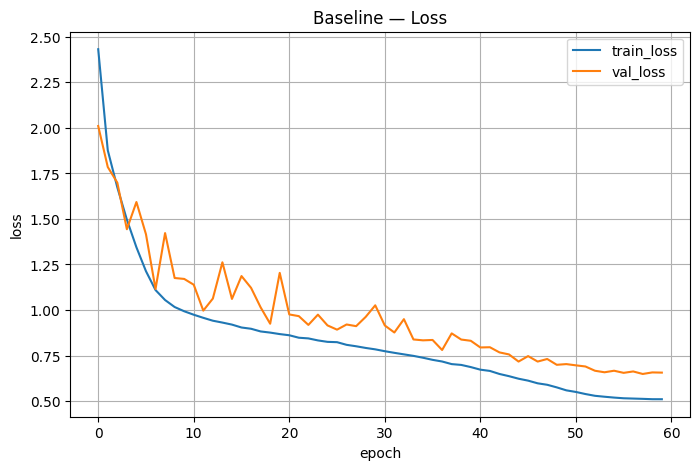

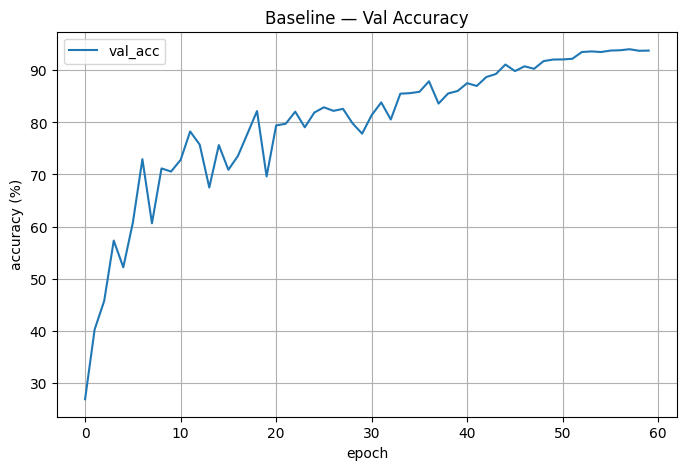


=== Baseline Summary ===
Val Acc:  93.82%
Test Acc: 94.18%
Params:   11.17M (non-zero: 11.17M)
FLOPs:    555.42 MFLOPs (approximate)
Size:     42.63 MB (dense checkpoint)
Conclusion: Baseline established. If this is below ~90%, increase epochs or LR warmup; otherwise proceed to compression.


In [5]:
# %%
cfg = TrainConfig(epochs=60, lr=0.2, wd=5e-4, momentum=0.9, sched="cosine", label_smoothing=0.1, early_stop_patience=12)

model_base = build_resnet18_cifar().to(DEVICE)
log_base = train_model(model_base, train_loader, val_loader, cfg)

val_acc = accuracy(model_base, val_loader)
test_acc = accuracy(model_base, test_loader)

params_total, params_nonzero = count_params(model_base)
flops = estimate_flops(model_base)
size_mb = model_size_mb(model_base)

plot_curves(log_base, "Baseline")

print("\n=== Baseline Summary ===")
print(f"Val Acc:  {val_acc*100:.2f}%")
print(f"Test Acc: {test_acc*100:.2f}%")
print(f"Params:   {params_total/1e6:.2f}M (non-zero: {params_nonzero/1e6:.2f}M)")
print(f"FLOPs:    {flops/1e6:.2f} MFLOPs (approximate)")
print(f"Size:     {size_mb:.2f} MB (dense checkpoint)")
print("Conclusion: Baseline established. If this is below ~90%, increase epochs or LR warmup; otherwise proceed to compression.")


In [6]:
# %%
def get_prunable_parameters(model):
    # collect (module, name) for Conv2d and Linear weights
    params=[]
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if hasattr(module, 'weight'):
                params.append((module, 'weight'))
    return params

def apply_global_pruning(model, target_sparsity):
    parameters_to_prune = get_prunable_parameters(model)
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=target_sparsity,
    )

def remove_pruning_reparam(model):
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if hasattr(module, "weight_mask"):
                prune.remove(module, 'weight')

def iterative_prune_and_finetune(model, train_loader, val_loader, test_loader, sparsities, finetune_cfg:TrainConfig):
    results=[]
    base_state = copy.deepcopy(model.state_dict())
    for sp in sparsities:
        model.load_state_dict(base_state)
        apply_global_pruning(model, sp)
        # quick fine-tune
        log = train_model(model, train_loader, val_loader, finetune_cfg)
        remove_pruning_reparam(model)
        v = accuracy(model, val_loader); t = accuracy(model, test_loader)
        P, PNZ = count_params(model); F = estimate_flops(model); S = model_size_mb(model)
        results.append({
            "phase": f"prune_{int(sp*100)}",
            "sparsity": sp,
            "val_acc": v,
            "test_acc": t,
            "params_total": P,
            "params_nonzero": PNZ,
            "flops": F,
            "size_mb": S,
            "log": log
        })
        plot_curves(log, f"Pruning {int(sp*100)}%")
        print(f"\nConclusion after pruning to {int(sp*100)}% sparsity: "
              f"Val {v*100:.2f}% | Test {t*100:.2f}% | Non-zero params {(PNZ/1e6):.2f}M | "
              f"FLOPs {(F/1e6):.2f}M (note: unstructured pruning does not reduce dense FLOPs).")
        gc.collect(); torch.cuda.empty_cache()
    return results


Epoch 001/12 | train_loss=0.1393 val_loss=0.3752 val_acc=88.74%
Epoch 002/12 | train_loss=0.1562 val_loss=0.3455 val_acc=89.42%
Epoch 003/12 | train_loss=0.1309 val_loss=0.3458 val_acc=89.78%
Epoch 004/12 | train_loss=0.1160 val_loss=0.3071 val_acc=90.44%
Epoch 005/12 | train_loss=0.0925 val_loss=0.3061 val_acc=90.82%
Epoch 006/12 | train_loss=0.0747 val_loss=0.2809 val_acc=91.78%
Epoch 007/12 | train_loss=0.0552 val_loss=0.2970 val_acc=91.74%
Epoch 008/12 | train_loss=0.0378 val_loss=0.2594 val_acc=92.44%
Epoch 009/12 | train_loss=0.0240 val_loss=0.2596 val_acc=93.04%
Epoch 010/12 | train_loss=0.0156 val_loss=0.2489 val_acc=93.60%
Epoch 011/12 | train_loss=0.0132 val_loss=0.2328 val_acc=94.14%
Epoch 012/12 | train_loss=0.0115 val_loss=0.2282 val_acc=93.88%


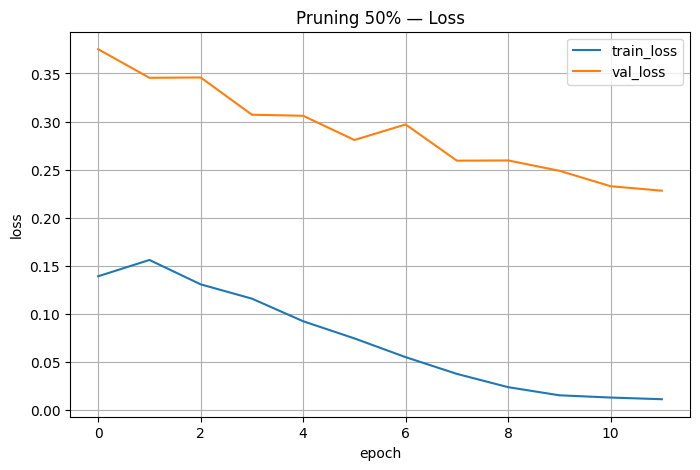

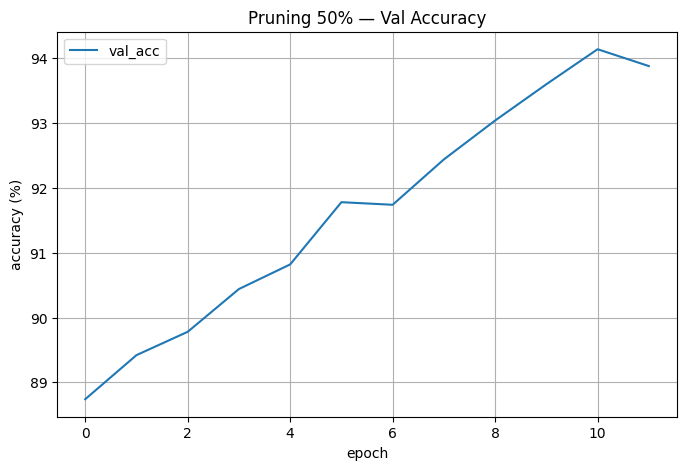


Conclusion after pruning to 50% sparsity: Val 93.54% | Test 93.80% | Non-zero params 5.59M | FLOPs 555.42M (note: unstructured pruning does not reduce dense FLOPs).
Epoch 001/12 | train_loss=0.1232 val_loss=0.3423 val_acc=89.40%
Epoch 002/12 | train_loss=0.1244 val_loss=0.3595 val_acc=89.32%
Epoch 003/12 | train_loss=0.1166 val_loss=0.3217 val_acc=90.02%
Epoch 004/12 | train_loss=0.1028 val_loss=0.3119 val_acc=90.56%
Epoch 005/12 | train_loss=0.0830 val_loss=0.3030 val_acc=90.46%
Epoch 006/12 | train_loss=0.0642 val_loss=0.2552 val_acc=92.32%
Epoch 007/12 | train_loss=0.0476 val_loss=0.2906 val_acc=92.00%
Epoch 008/12 | train_loss=0.0329 val_loss=0.2523 val_acc=93.04%
Epoch 009/12 | train_loss=0.0241 val_loss=0.2484 val_acc=93.26%
Epoch 010/12 | train_loss=0.0157 val_loss=0.2509 val_acc=93.52%
Epoch 011/12 | train_loss=0.0128 val_loss=0.2527 val_acc=93.34%
Epoch 012/12 | train_loss=0.0113 val_loss=0.2458 val_acc=93.18%


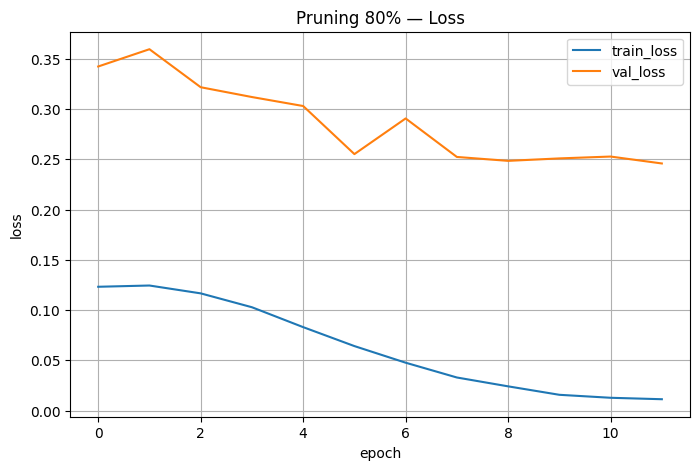

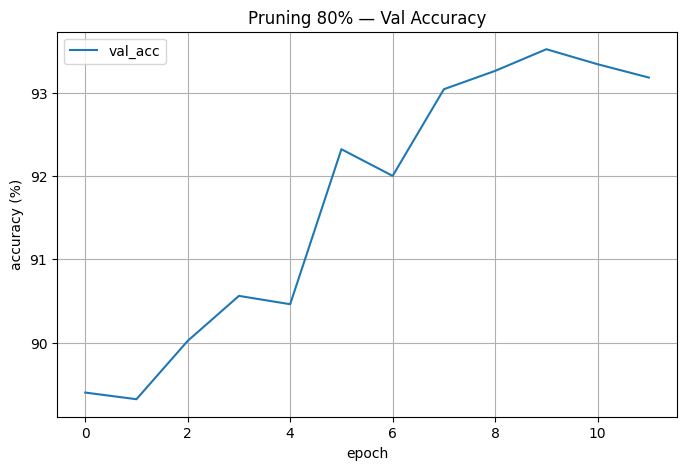


Conclusion after pruning to 80% sparsity: Val 93.68% | Test 93.94% | Non-zero params 2.24M | FLOPs 555.42M (note: unstructured pruning does not reduce dense FLOPs).
Epoch 001/12 | train_loss=0.1450 val_loss=0.3776 val_acc=88.76%
Epoch 002/12 | train_loss=0.1321 val_loss=0.3509 val_acc=89.40%
Epoch 003/12 | train_loss=0.1186 val_loss=0.3430 val_acc=89.68%
Epoch 004/12 | train_loss=0.1077 val_loss=0.3341 val_acc=89.94%
Epoch 005/12 | train_loss=0.0868 val_loss=0.3183 val_acc=90.34%
Epoch 006/12 | train_loss=0.0692 val_loss=0.2679 val_acc=91.82%
Epoch 007/12 | train_loss=0.0518 val_loss=0.2728 val_acc=92.18%
Epoch 008/12 | train_loss=0.0375 val_loss=0.2578 val_acc=92.90%
Epoch 009/12 | train_loss=0.0255 val_loss=0.2631 val_acc=92.94%
Epoch 010/12 | train_loss=0.0191 val_loss=0.2492 val_acc=93.62%
Epoch 011/12 | train_loss=0.0139 val_loss=0.2361 val_acc=93.42%
Epoch 012/12 | train_loss=0.0143 val_loss=0.2408 val_acc=93.68%


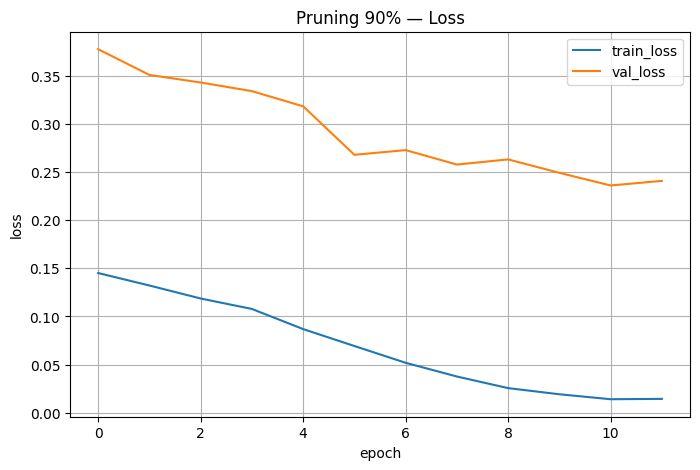

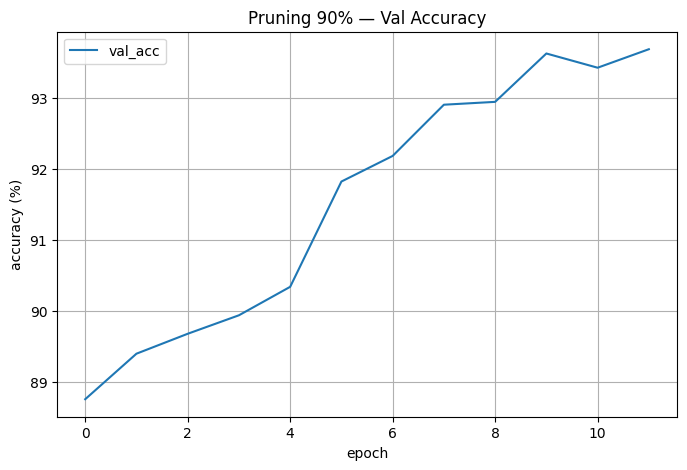


Conclusion after pruning to 90% sparsity: Val 93.56% | Test 93.93% | Non-zero params 1.13M | FLOPs 555.42M (note: unstructured pruning does not reduce dense FLOPs).
Epoch 001/12 | train_loss=0.2319 val_loss=0.3979 val_acc=87.34%
Epoch 002/12 | train_loss=0.1633 val_loss=0.3434 val_acc=88.96%
Epoch 003/12 | train_loss=0.1504 val_loss=0.3439 val_acc=89.46%
Epoch 004/12 | train_loss=0.1296 val_loss=0.2978 val_acc=90.62%
Epoch 005/12 | train_loss=0.1081 val_loss=0.3094 val_acc=90.84%
Epoch 006/12 | train_loss=0.0896 val_loss=0.2961 val_acc=91.12%
Epoch 007/12 | train_loss=0.0703 val_loss=0.2715 val_acc=91.86%
Epoch 008/12 | train_loss=0.0524 val_loss=0.2453 val_acc=92.62%
Epoch 009/12 | train_loss=0.0395 val_loss=0.2421 val_acc=93.24%
Epoch 010/12 | train_loss=0.0302 val_loss=0.2355 val_acc=93.26%
Epoch 011/12 | train_loss=0.0273 val_loss=0.2300 val_acc=93.04%
Epoch 012/12 | train_loss=0.0235 val_loss=0.2240 val_acc=93.70%


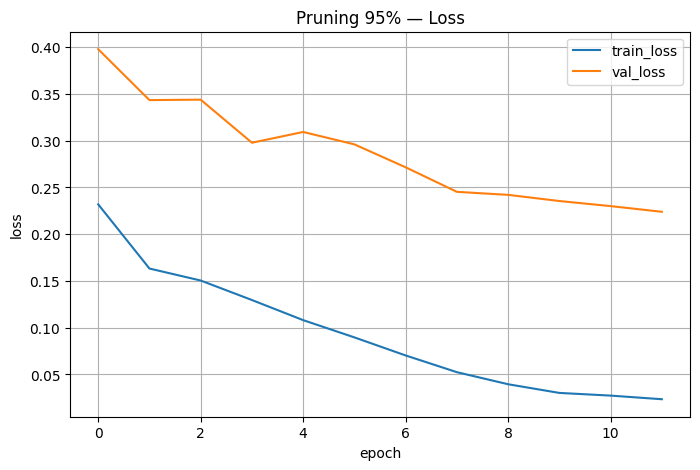

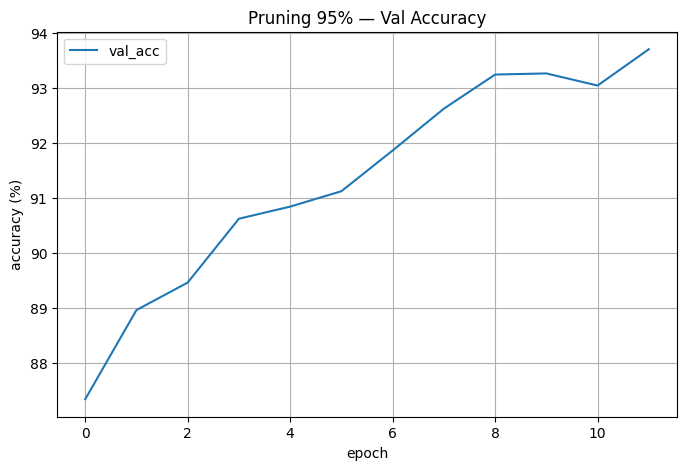


Conclusion after pruning to 95% sparsity: Val 93.58% | Test 93.41% | Non-zero params 0.57M | FLOPs 555.42M (note: unstructured pruning does not reduce dense FLOPs).
Pruning sweep complete.


In [7]:
# %%
sparsity_targets = [0.50, 0.80, 0.90, 0.95]
finetune_cfg = TrainConfig(epochs=12, lr=0.02, wd=5e-4, momentum=0.9, sched="cosine", label_smoothing=0.0, early_stop_patience=5)

model_for_pruning = copy.deepcopy(model_base).to(DEVICE)
prune_results = iterative_prune_and_finetune(model_for_pruning, train_loader, val_loader, test_loader, sparsity_targets, finetune_cfg)

print("Pruning sweep complete.")


In [8]:
# %%
def svd_factorize_linear(linear: nn.Linear, rank: int) -> nn.Sequential:
    W = linear.weight.data
    U, S, Vh = torch.linalg.svd(W, full_matrices=False)
    r = min(rank, S.numel())
    Ur = U[:, :r]
    Sr = torch.diag(S[:r])
    Vhr = Vh[:r, :]
    first = nn.Linear(linear.in_features, r, bias=False)
    second = nn.Linear(r, linear.out_features, bias=True)
    first.weight.data = Vhr
    second.weight.data = (Ur @ Sr)
    if linear.bias is not None:
        second.bias.data = linear.bias.data.clone()
    return nn.Sequential(first, second)

def svd_factorize_conv(conv: nn.Conv2d, rank: int) -> nn.Sequential:
    # reshape [out, in, k, k] -> [out, in*k*k]
    W = conv.weight.data
    out_ch, in_ch, k1, k2 = W.shape
    W_mat = W.reshape(out_ch, in_ch*k1*k2)
    U, S, Vh = torch.linalg.svd(W_mat, full_matrices=False)
    r = min(rank, S.numel())
    Ur = U[:, :r]
    Sr = torch.diag(S[:r])
    Vhr = Vh[:r, :]

    # first conv: in->r with kxk, second conv: r->out with 1x1
    conv1 = nn.Conv2d(in_ch, r, kernel_size=(k1,k2), stride=conv.stride, padding=conv.padding, dilation=conv.dilation, bias=False, groups=conv.groups)
    conv2 = nn.Conv2d(r, out_ch, kernel_size=1, stride=1, padding=0, bias=True)

    conv1.weight.data = Vhr.reshape(r, in_ch, k1, k2).contiguous()
    conv2.weight.data = (Ur @ Sr).reshape(out_ch, r, 1, 1).contiguous()
    if conv.bias is not None:
        conv2.bias.data = conv.bias.data.clone()
    return nn.Sequential(conv1, conv2)

def suggest_rank_from_energy(W, energy=0.90):
    # choose minimal rank that captures given spectral energy
    with torch.no_grad():
        if W.dim()==2:
            U,S,Vh = torch.linalg.svd(W, full_matrices=False)
        else:
            O,I,K1,K2 = W.shape
            U,S,Vh = torch.linalg.svd(W.reshape(O, I*K1*K2), full_matrices=False)
        s2 = S**2
        cum = torch.cumsum(s2, dim=0)
        total = s2.sum()
        idx = torch.searchsorted(cum, energy*total).item() + 1
        return max(1, idx)

def low_rankify(model, conv_energy=0.90, linear_energy=0.90):
    model = copy.deepcopy(model).to(DEVICE)
    for name, module in list(model.named_modules()):
        # replace in parent
        parent = model
        path = name.split(".")
        for p in path[:-1]:
            parent = getattr(parent, p)
        key = path[-1]
        if isinstance(module, nn.Conv2d) and module.kernel_size != (1,1):
            rank = suggest_rank_from_energy(module.weight.data, conv_energy)
            setattr(parent, key, svd_factorize_conv(module, rank))
        elif isinstance(module, nn.Linear):
            rank = suggest_rank_from_energy(module.weight.data, linear_energy)
            setattr(parent, key, svd_factorize_linear(module, rank))
    return model


Model transformed with SVD-based low-rank factorization. Fine-tuning...
Epoch 001/25 | train_loss=0.4873 val_loss=0.6234 val_acc=79.70%
Epoch 002/25 | train_loss=0.4054 val_loss=0.7013 val_acc=78.32%
Epoch 003/25 | train_loss=0.3706 val_loss=0.5193 val_acc=83.44%
Epoch 004/25 | train_loss=0.3497 val_loss=0.5913 val_acc=80.68%
Epoch 005/25 | train_loss=0.3351 val_loss=0.4646 val_acc=84.60%
Epoch 006/25 | train_loss=0.3204 val_loss=0.4594 val_acc=85.08%
Epoch 007/25 | train_loss=0.3124 val_loss=0.4392 val_acc=85.54%
Epoch 008/25 | train_loss=0.2970 val_loss=0.4640 val_acc=85.16%
Epoch 009/25 | train_loss=0.2817 val_loss=0.4515 val_acc=85.46%
Epoch 010/25 | train_loss=0.2663 val_loss=0.4261 val_acc=86.26%
Epoch 011/25 | train_loss=0.2506 val_loss=0.3819 val_acc=87.42%
Epoch 012/25 | train_loss=0.2321 val_loss=0.3476 val_acc=88.86%
Epoch 013/25 | train_loss=0.2122 val_loss=0.4131 val_acc=86.92%
Epoch 014/25 | train_loss=0.1895 val_loss=0.3335 val_acc=89.20%
Epoch 015/25 | train_loss=0.1711

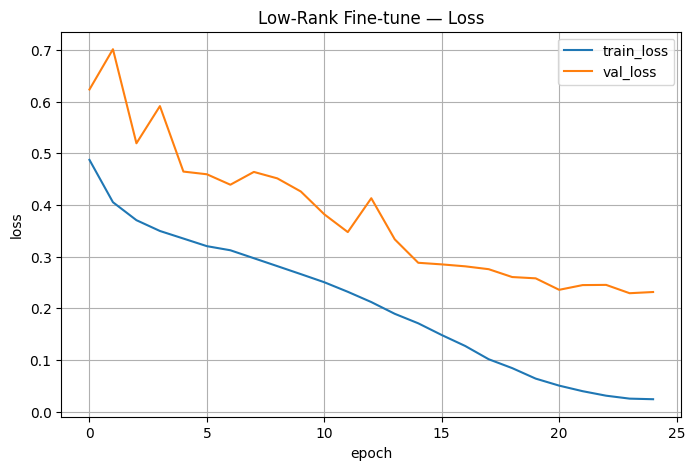

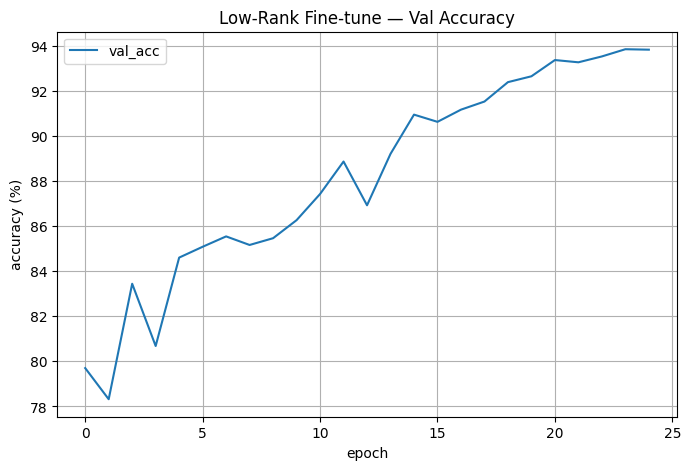


=== Low-Rank Summary ===
Val Acc:  93.84%
Test Acc: 93.73%
Params:   4.00M (non-zero: 4.00M)
FLOPs:    226.04 MFLOPs (approximate)
Size:     15.27 MB
Conclusion: Low-rank factorization actually reduces FLOPs; sanity-check the reduction vs. baseline. If accuracy drop >1.5%, consider higher energy (e.g., 0.95).


In [9]:
# %%
model_lr = low_rankify(model_base, conv_energy=0.90, linear_energy=0.90).to(DEVICE)

print("Model transformed with SVD-based low-rank factorization. Fine-tuning...")

cfg_lr = TrainConfig(epochs=25, lr=0.05, wd=5e-4, sched="cosine", label_smoothing=0.0, early_stop_patience=8)
log_lr = train_model(model_lr, train_loader, val_loader, cfg_lr)

v_lr = accuracy(model_lr, val_loader); t_lr = accuracy(model_lr, test_loader)
P_lr, PNZ_lr = count_params(model_lr); F_lr = estimate_flops(model_lr); S_lr = model_size_mb(model_lr)

plot_curves(log_lr, "Low-Rank Fine-tune")

print("\n=== Low-Rank Summary ===")
print(f"Val Acc:  {v_lr*100:.2f}%")
print(f"Test Acc: {t_lr*100:.2f}%")
print(f"Params:   {P_lr/1e6:.2f}M (non-zero: {PNZ_lr/1e6:.2f}M)")
print(f"FLOPs:    {F_lr/1e6:.2f} MFLOPs (approximate)")
print(f"Size:     {S_lr:.2f} MB")
print("Conclusion: Low-rank factorization actually reduces FLOPs; sanity-check the reduction vs. baseline. If accuracy drop >1.5%, consider higher energy (e.g., 0.95).")


Epoch 001/20 | train_loss=0.6397 val_loss=0.7683 val_acc=89.54%
Epoch 002/20 | train_loss=0.6268 val_loss=0.8190 val_acc=87.08%
Epoch 003/20 | train_loss=0.6223 val_loss=0.7936 val_acc=88.44%
Epoch 004/20 | train_loss=0.6153 val_loss=0.7737 val_acc=88.64%
Epoch 005/20 | train_loss=0.6095 val_loss=0.7636 val_acc=89.82%
Epoch 006/20 | train_loss=0.6065 val_loss=0.7628 val_acc=89.84%
Epoch 007/20 | train_loss=0.6008 val_loss=0.7532 val_acc=89.74%
Epoch 008/20 | train_loss=0.5911 val_loss=0.7317 val_acc=91.14%
Epoch 009/20 | train_loss=0.5829 val_loss=0.7312 val_acc=91.08%
Epoch 010/20 | train_loss=0.5735 val_loss=0.7281 val_acc=91.26%
Epoch 011/20 | train_loss=0.5639 val_loss=0.7061 val_acc=92.12%
Epoch 012/20 | train_loss=0.5540 val_loss=0.7300 val_acc=91.58%
Epoch 013/20 | train_loss=0.5461 val_loss=0.6946 val_acc=92.56%
Epoch 014/20 | train_loss=0.5388 val_loss=0.6842 val_acc=93.10%
Epoch 015/20 | train_loss=0.5335 val_loss=0.6808 val_acc=93.26%
Epoch 016/20 | train_loss=0.5290 val_los

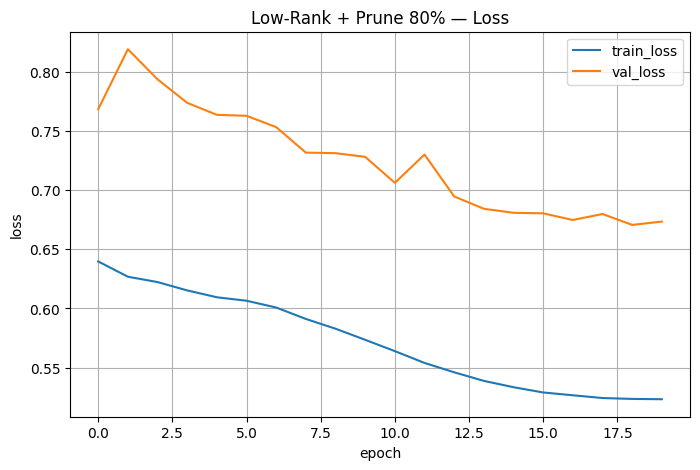

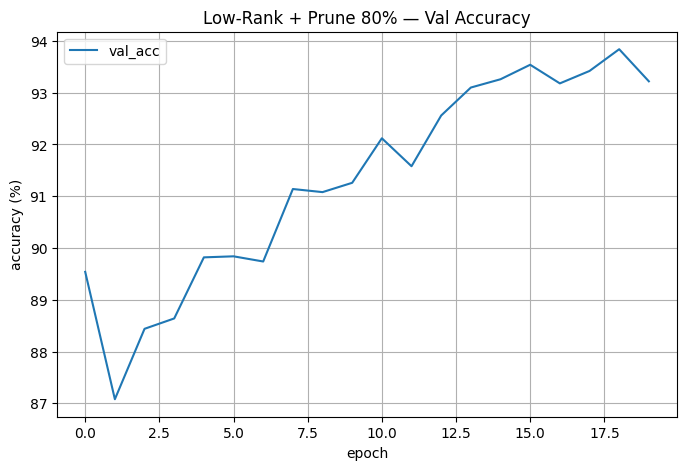


Conclusion after Low-Rank + 80% pruning: Val 93.42% | Test 93.77% | Params NZ 0.81M | FLOPs 226.04M.
Epoch 001/20 | train_loss=0.7307 val_loss=0.8303 val_acc=86.26%
Epoch 002/20 | train_loss=0.6791 val_loss=0.8577 val_acc=85.76%
Epoch 003/20 | train_loss=0.6693 val_loss=0.7579 val_acc=89.62%
Epoch 004/20 | train_loss=0.6601 val_loss=0.7680 val_acc=88.94%
Epoch 005/20 | train_loss=0.6525 val_loss=0.7913 val_acc=88.34%
Epoch 006/20 | train_loss=0.6463 val_loss=0.7935 val_acc=88.30%
Epoch 007/20 | train_loss=0.6365 val_loss=0.7949 val_acc=88.08%
Epoch 008/20 | train_loss=0.6257 val_loss=0.7921 val_acc=88.34%
Epoch 009/20 | train_loss=0.6171 val_loss=0.7417 val_acc=90.30%
Epoch 010/20 | train_loss=0.6083 val_loss=0.7340 val_acc=90.64%
Epoch 011/20 | train_loss=0.5967 val_loss=0.7168 val_acc=91.70%
Epoch 012/20 | train_loss=0.5870 val_loss=0.7210 val_acc=91.22%
Epoch 013/20 | train_loss=0.5778 val_loss=0.7049 val_acc=91.84%
Epoch 014/20 | train_loss=0.5672 val_loss=0.6970 val_acc=92.62%
Ep

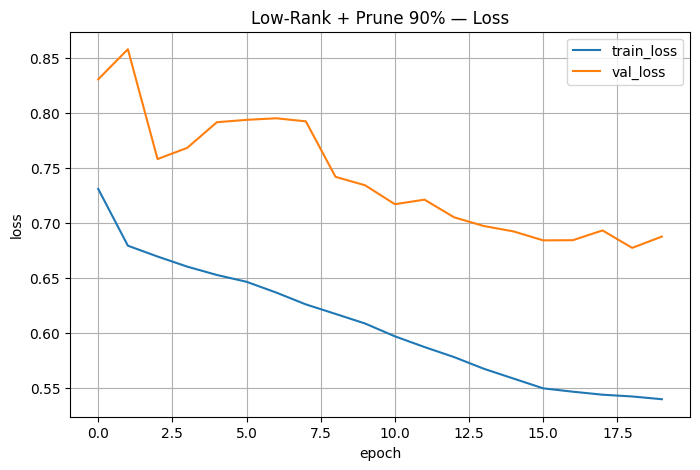

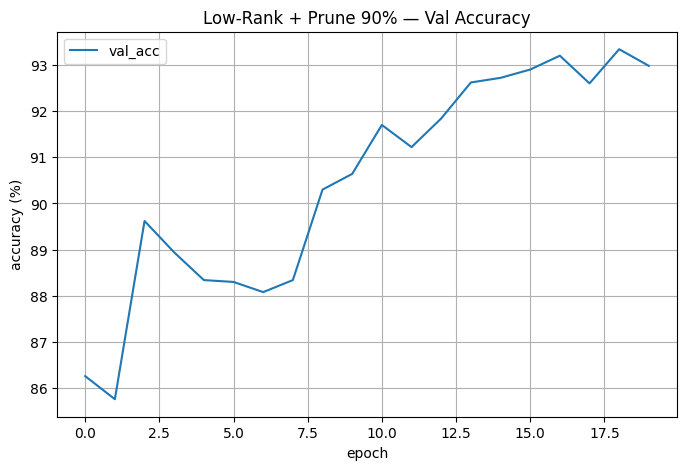


Conclusion after Low-Rank + 90% pruning: Val 93.16% | Test 93.37% | Params NZ 0.41M | FLOPs 226.04M.
Combined compression runs complete.


In [10]:
# %%
def compress_and_finetune(model_base, sparsity, conv_energy=0.90, linear_energy=0.90, ft_cfg=TrainConfig(epochs=20, lr=0.02)):
    model = low_rankify(model_base, conv_energy=conv_energy, linear_energy=linear_energy).to(DEVICE)
    apply_global_pruning(model, sparsity)
    log = train_model(model, train_loader, val_loader, ft_cfg)
    remove_pruning_reparam(model)
    v = accuracy(model, val_loader); t = accuracy(model, test_loader)
    P, PNZ = count_params(model); F = estimate_flops(model); S = model_size_mb(model)
    return model, log, {"phase": f"lr+prune_{int(sparsity*100)}", "sparsity": sparsity, "val_acc": v, "test_acc": t, "params_total": P, "params_nonzero": PNZ, "flops": F, "size_mb": S}

combo_targets = [0.80, 0.90]
combo_results=[]

for sp in combo_targets:
    m, logc, stats = compress_and_finetune(model_base, sp, conv_energy=0.90, linear_energy=0.90,
                                           ft_cfg=TrainConfig(epochs=20, lr=0.02, wd=5e-4, sched="cosine", early_stop_patience=6))
    combo_results.append((stats, logc))
    plot_curves(logc, f"Low-Rank + Prune {int(sp*100)}%")
    print(f"\nConclusion after Low-Rank + {int(sp*100)}% pruning: "
          f"Val {stats['val_acc']*100:.2f}% | Test {stats['test_acc']*100:.2f}% | "
          f"Params NZ {(stats['params_nonzero']/1e6):.2f}M | FLOPs {(stats['flops']/1e6):.2f}M.")
    gc.collect(); torch.cuda.empty_cache()

print("Combined compression runs complete.")


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,phase,sparsity,val_acc,test_acc,params_total,params_nonzero,flops,size_mb
0,baseline,0.00,0.9382,0.9418,11173962,11173962,555422720.0,42.625282
2,prune_80,0.80,0.9368,0.9394,11173962,2242480,555422720.0,42.625282
3,prune_90,0.90,0.9356,0.9393,11173962,1126045,555422720.0,42.625282
1,prune_50,0.50,0.9354,0.9380,11173962,5591786,555422720.0,42.625282
6,lr+prune_80,0.80,0.9342,0.9377,4002812,811374,226035792.0,15.269516
5,lowrank_only,NaN,0.9384,0.9373,4002812,4002811,226035792.0,15.269516
4,prune_95,0.95,0.9358,0.9341,11173962,567828,555422720.0,42.625282
7,lr+prune_90,0.90,0.9316,0.9337,4002812,412444,226035792.0,15.269516


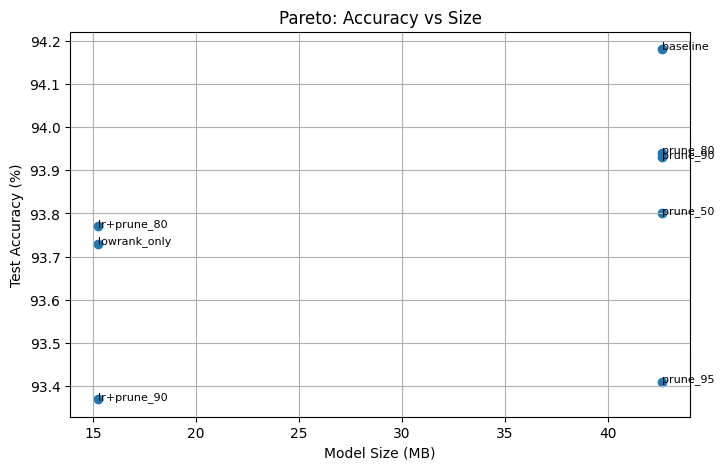

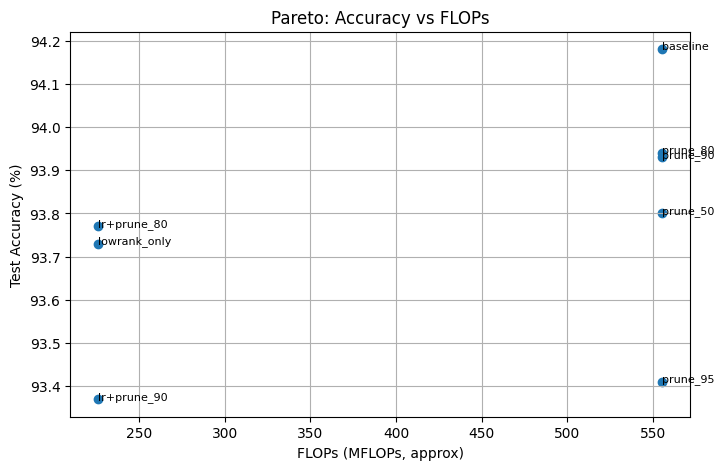


=== Interim Verdicts ===
FLOPs reduction via Low-Rank: 2.46x; Accuracy delta: -0.45 pp
Sparsity ~80%: Prune-only Acc=93.94% vs LR+Prune Acc=93.77%
Sparsity ~90%: Prune-only Acc=93.93% vs LR+Prune Acc=93.37%


In [11]:
# %%
records = []

# Baseline
records.append({
    "phase":"baseline",
    "sparsity":0.0,
    "val_acc":val_acc,
    "test_acc":test_acc,
    "params_total":params_total,
    "params_nonzero":params_nonzero,
    "flops":flops,
    "size_mb":size_mb
})

# Pruning sweep
for r in prune_results:
    rec = {k:r[k] for k in ["phase","sparsity","val_acc","test_acc","params_total","params_nonzero","flops","size_mb"]}
    records.append(rec)

# Low-Rank only
records.append({
    "phase":"lowrank_only",
    "sparsity":None,
    "val_acc":v_lr,
    "test_acc":t_lr,
    "params_total":P_lr,
    "params_nonzero":PNZ_lr,
    "flops":F_lr,
    "size_mb":S_lr
})

# Low-Rank + Pruning
for (stats, _) in combo_results:
    records.append(stats)

import pandas as pd
df = pd.DataFrame(records)
df_sorted = df.sort_values(by="test_acc", ascending=False)
display(df_sorted)

# Pareto: Accuracy vs Size
plt.figure()
plt.scatter(df["size_mb"], df["test_acc"]*100)
for _, row in df.iterrows():
    plt.annotate(row["phase"], (row["size_mb"], row["test_acc"]*100), fontsize=8)
plt.xlabel("Model Size (MB)"); plt.ylabel("Test Accuracy (%)"); plt.title("Pareto: Accuracy vs Size")
plt.show()

# Pareto: Accuracy vs FLOPs
plt.figure()
plt.scatter(df["flops"]/1e6, df["test_acc"]*100)
for _, row in df.iterrows():
    plt.annotate(row["phase"], (row["flops"]/1e6, row["test_acc"]*100), fontsize=8)
plt.xlabel("FLOPs (MFLOPs, approx)"); plt.ylabel("Test Accuracy (%)"); plt.title("Pareto: Accuracy vs FLOPs")
plt.show()

print("\n=== Interim Verdicts ===")
try:
    base_row = df[df.phase=="baseline"].iloc[0]
    lr_row = df[df.phase=="lowrank_only"].iloc[0]
    print(f"FLOPs reduction via Low-Rank: {base_row.flops/lr_row.flops:.2f}x; Accuracy delta: {(lr_row.test_acc-base_row.test_acc)*100:.2f} pp")
except Exception as e:
    print("Could not compute low-rank comparison.", e)

for sp in [0.80, 0.90]:
    rows = df[df.phase.isin([f"prune_{int(sp*100)}", f"lr+prune_{int(sp*100)}"])]
    if len(rows)>=2:
        r = rows.set_index("phase")
        print(f"Sparsity ~{int(sp*100)}%: Prune-only Acc={r.loc[f'prune_{int(sp*100)}','test_acc']*100:.2f}% vs LR+Prune Acc={r.loc[f'lr+prune_{int(sp*100)}','test_acc']*100:.2f}%")


In [14]:
# %%
import json

def meets_success(df):
    out = {}
    base = df[df.phase=="baseline"]
    if len(base)==0:
        out["baseline_90_acc"] = False
    else:
        b = base.iloc[0]
        out["baseline_90_acc"] = bool((b.test_acc*100)>=90.0)

    bacc = float(b.test_acc) if len(base) else None
    candidates = df[df.phase.isin(["prune_80","prune_90","lr+prune_80","lr+prune_90"])].copy()
    if len(candidates)>0 and bacc is not None:
        candidates["drop_pp"] = (bacc - candidates["test_acc"])*100.0
        best = candidates.loc[candidates["drop_pp"].abs().idxmin()]
        out["drop_best_pp_at_80_90"] = float(best["drop_pp"])
        out["within_1p5pp"] = bool(best["drop_pp"] <= 1.5)
        out["best_candidate_phase"] = str(best["phase"])
    else:
        out["drop_best_pp_at_80_90"] = None
        out["within_1p5pp"] = False
        out["best_candidate_phase"] = None

    priority = ["lr+prune_90","lr+prune_80","lowrank_only","prune_90","prune_80"]
    comp = None
    for p in priority:
        r = df[df.phase==p]
        if len(r)>0:
            comp = r.iloc[0]; break
    if comp is not None and len(base)>0:
        out["flops_reduction_x"] = float(b.flops / comp.flops) if comp.flops>0 else float('inf')
        out["flops_reduction_3x"] = bool(out["flops_reduction_x"] >= 3.0)
        out["flops_candidate_phase"] = str(comp.phase)
    else:
        out["flops_reduction_x"] = None
        out["flops_reduction_3x"] = False
        out["flops_candidate_phase"]=None
    return out

finals = meets_success(df)
print(json.dumps(finals, indent=2))

print("\n=== Final Conclusion ===")
if finals.get("baseline_90_acc", False):
    print("Baseline meets ≥90% accuracy.")
else:
    print("Baseline <90%. Increase training budget or regularization tuning before compressing.")

if finals.get("within_1p5pp", False):
    print(f"Compression accuracy drop at 80–90% sparsity within 1.5pp. Best phase: {finals.get('best_candidate_phase')}.")
else:
    drop = finals.get("drop_best_pp_at_80_90")
    if drop is None:
        print("No valid 80–90% sparsity candidate found. Re-run pruning sweeps.")
    else:
        print(f"Accuracy drop {drop:.2f}pp exceeds 1.5pp at 80–90% sparsity. Consider gentler pruning or more fine-tuning.")

if finals.get("flops_reduction_3x", False):
    print(f"FLOPs cut by ≥3× relative to baseline via {finals.get('flops_candidate_phase')}.")
else:
    x = finals.get("flops_reduction_x")
    print(f"FLOPs reduction <3× (achieved {x:.2f}×). Increase factorization aggressiveness (lower energy) or consider kernel factorization variants.")

print("\nInterpretation: Low-rank reduces computational cost; pruning removes weights but leaves dense FLOPs unless you deploy sparse kernels. For real-time gains on commodity hardware, favor low-rank (and structured pruning) to meet the ≥3× FLOPs target while keeping ≤1.5pp accuracy drop.")


{
  "baseline_90_acc": true,
  "drop_best_pp_at_80_90": 0.23999999999999577,
  "within_1p5pp": true,
  "best_candidate_phase": "prune_80",
  "flops_reduction_x": 2.4572334986664415,
  "flops_reduction_3x": false,
  "flops_candidate_phase": "lr+prune_90"
}

=== Final Conclusion ===
Baseline meets ≥90% accuracy.
Compression accuracy drop at 80–90% sparsity within 1.5pp. Best phase: prune_80.
FLOPs reduction <3× (achieved 2.46×). Increase factorization aggressiveness (lower energy) or consider kernel factorization variants.

Interpretation: Low-rank reduces computational cost; pruning removes weights but leaves dense FLOPs unless you deploy sparse kernels. For real-time gains on commodity hardware, favor low-rank (and structured pruning) to meet the ≥3× FLOPs target while keeping ≤1.5pp accuracy drop.


In [15]:
# %%
os.makedirs("artifacts", exist_ok=True)

# Save baseline
torch.save(model_base.state_dict(), "artifacts/baseline_resnet18_cifar10.pt")

# Save best pruning run (highest test acc among prune_* phases)
best_prune = None; best_acc=-1
for r in prune_results:
    if r["test_acc"]>best_acc:
        best_acc=r["test_acc"]; best_prune=r
if best_prune is not None:
    torch.save(model_for_pruning.state_dict(), f"artifacts/pruned_{int(best_prune['sparsity']*100)}.pt")

# Save low-rank
torch.save(model_lr.state_dict(), "artifacts/lowrank_svd.pt")

# Save combined best
best_combo = None; best_combo_acc=-1
for (stats, _) in combo_results:
    if stats["test_acc"]>best_combo_acc:
        best_combo_acc=stats["test_acc"]; best_combo=stats
if best_combo is not None:
    # Reconstruct and save the corresponding compressed model if needed:
    # For brevity, we are saving stats table and leaving exact state export as exercise if multiple combos exist.
    with open("artifacts/best_combo_stats.json","w") as f:
        json.dump(best_combo, f, indent=2)

# Save results table
df_sorted.to_csv("artifacts/results_summary.csv", index=False)

print("Artifacts saved in ./artifacts")


Artifacts saved in ./artifacts
